# Solving the Incompressible Semi-Geostrophic Problem in 3D

First load in the required packages and paths.

In [1]:
import initialconditions as ic
import matplotlib.pyplot as plt
import matplotlib as mp
import numpy as np
from solvers import mainAB2 
from solvers import mainHeun 
from solvers import mainRK4 
from solvers import mainDOPRI 
from solvers import mainAB2wWa 
from solvers import mainHeunAB2
from solvers import mainCN

import random

Next define the system parameters.

In [2]:
# Define the parameters of the system

# box = [0, 0, 0, 1, 1, 1]
box = [-3.66, -1.75, 0, 3.66, 1.75, 0.45] # List or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 # Percent tolerance
per_x = True # Set the periodicity of X
per_y = False # Set the periodicity of Y
per_z = False # Set the periodicity of Z
tf = 52 # Final time
Ndt = 150 # Number of timesteps

Define the initial condition and visualise it.

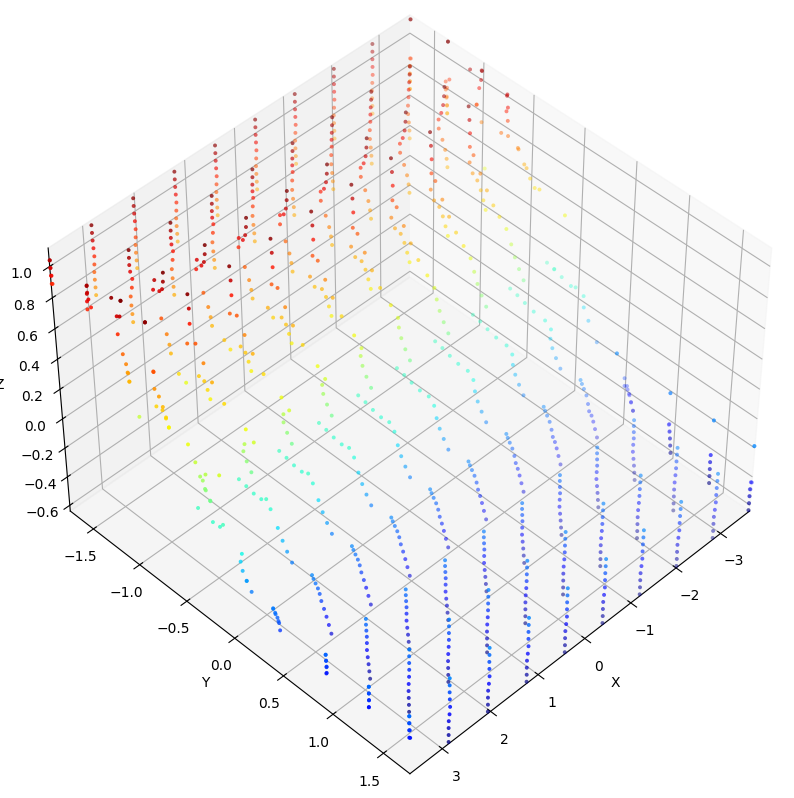

In [3]:
# Define the parameters and initialize an initial condition that is a perturbation of a steady background state

# N = 1000
# B = np.array([[1, 2, 3], [2, 4, 5], [3, 5, 6]]) #Create background steady state
# Z = ic.create_ss_initial(N, B, box, 'Thermal Sine') #Initial seed positions as a perturbation of a steady state

# Define the parameters and initialize an initial condition that is an isolated cyclone

N = 10 ** 3 # Number of seeds
A = 0 # Shear parameter can either be 0 or +/-0.1
Z = ic.create_cyc_initial(N, box, A, per_x, per_y, per_z, truncation = 16) #Initial seed positions for an isolated cyclone with no shear, shear can be set to +/-0.1

# N = 10
# Z = np.array([(random.uniform(box[0] + 0.45, box[3] - 0.45),
#               random.uniform(box[1]+ 0.45, box[4] - 0.45),
#               random.uniform(box[2]+ 0.45, box[5] - 0.45)) for _ in range(N)]) # Place the seeds randomly

# Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot(projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c = Z[:,2], cmap = 'jet', edgecolor = 'none', s = 8) #Points colored based on their 3rd component i.e. temperature
ax.set_xlim([np.min(Z[:,0]), np.max(Z[:,0])])
ax.set_ylim([np.min(Z[:,1]), np.max(Z[:,1])])
ax.set_zlim([np.min(Z[:,2]), np.max(Z[:,2])])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev = 45, azim = 45) #Viewing angle on the inital conditions

plt.show()

Solve the problem and save the data

In [ ]:
# mainAB2.SG_solver(box, Z, per_tol, tf, Ndt, per_x, per_y, per_z, debug = True) #Solve and save the solution 
# mainHeun.SG_solver(box, Z, per_tol, tf, Ndt, per_x, per_y, per_z, debug = True) #Solve and save the solution 
# mainRK4.SG_solver(box, Z, per_tol, tf, Ndt, per_x, per_y, per_z, debug = True) #Solve and save the solution 
# mainDOPRI.SG_solver(box, Z, per_tol, tf, Ndt, per_x, per_y, per_z, debug = True) #Solve and save the solution 
# mainAB2wWa.SG_solver(box, Z, per_tol, tf, Ndt, per_x, per_y, per_z, debug = True) #Solve and save the solution 
mainCN.SG_solver(box, Z, per_tol, tf, Ndt, per_x, per_y, per_z, debug = True) #Solve and save the solution

#Can activate the optional variables solver, and debug to control which linear solver the code uses and whether or not the code is in debug mode.

# Animations

First animate the particles

In [ ]:
import animators as ani

# Animate the particles 

#ani.point_animator('./data/CN_SG_data.msgpack', 'C', '2D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
#ani.point_animator('./data/SG_data.msgpack', 'C', '3D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./data/CN_SG_data.msgpack', 'Z', '2D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
#ani.point_animator('./data/SG_data.msgpack', 'Z', '3D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'

Next load in the data to animate the cells

In [7]:
import auxfunctions as aux

# Load the data from the MessagePack file
Z, C, W, M, TC = aux.load_data('./PaperData/RK4_SG_data_10-3_32_30.msgpack')

# Compute the Velocities, Temperature, and Kinetic Energy
MVel, ZVel, TVel, T, E, Eerr = aux.get_properties(Z, C, TC)

In [ ]:
# Calculate time in days for each timestep
time_steps = np.arange(len(E))
days = time_steps / 96.0  # Convert timesteps to days

# Create a line plot
plt.plot(days, E - 3.7988)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Add labels and title
plt.xlabel('Time (Days)')
plt.ylabel('Fluctuations in Total Energy')
plt.title('Evolution of Fluctuations in Total Energy')
# plt.ylabel('Error in Total Energy')
# plt.title('Evolution of Error in Total Energy')
# plt.ylabel('Total Energy')
#plt.ylim(0, 4)
# plt.title('Evolution of Total Energy')

# Save the figure
plt.savefig('total_energy_flux_evolution_3D.png', dpi=300)  # Save as high-resolution PNG file
#plt.savefig('error_total_energy_evolution_3D.png', dpi=300)  # Save as high-resolution PNG file
#plt.savefig('total_energy_evolution_3D.png', dpi=300)  # Save as high-resolution PNG file

plt.show()

Plot the Seeds and Centroids

In [ ]:
import animators as ani

bounds = ani.get_animation_bounds(Z)
fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
for i in [192, 384, 576, 768, 960, 1200]:
    scatter = ax.scatter(Z[i][:,0], Z[i][:,1], c=Z[i][:,2], cmap='jet', edgecolor='none', s=10) 
    ax.set_xlim([bounds[0], bounds[3]])
    ax.set_ylim([bounds[1], bounds[4]])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Calculate day number
    day_id = i // 48  # Using integer division to get whole number days

    # Save the figure
    filename = f'seeds_day_{day_id}_3D.png'
    plt.savefig(filename, dpi=300)  # Save as high-resolution PNG file

# Create the color bar
# cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
# cbar.set_label('Temperature')

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 0.5))

# Define minimum and maximum values for the color bar
# vmin = np.min(Z[:,:,2])
# vmax = np.max(Z[:,:,2])
# vmin = np.min(TVel)
# vmax = np.max(TVel)
vmin = 0
vmax = 1.75

# Create a colormap and a normalization instance
cmap = plt.cm.jet
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Create a ScalarMappable and set the colormap and normalization
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar to function properly

# Create the color bar
cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')

# Set the label for the color bar
cbar.set_label('Magnitude of Total Velocity', fontsize=15)

# Save the figure as a PNG with 300 DPI
plt.savefig('shear_colour_bar.png', dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()

Plot Cells

In [ ]:
import optimaltransportsolver as ots
from pysdot import PowerDiagram
import pyvista as pv

# Time to plot at
i = 192
# Set path to save the image
image_path = 'TVel_4_A=-0.5.png'  # Specify your desired image file path

# Pick colouring
coloring = 'TVel' # Chose how to colour the cells can be temperature ('Temp'), meridional velocity ('MVel') 

# Define a dictionary to map the coloring options to cell data attribute names
coloring_to_attr_name = {
    'Temp': 'Temperature',
    'MVel': 'Meridional Velocity',
    'ZVel': 'Zonal Velocity',
    'TVel': 'Magnitude of Total Velocity'
}

#Construct domain
domain = ots.make_domain(box, False, False, False)

#Draw the tessellation
Lx, Ly, Lz = [abs(box[i+3] - box[i]) for i in range(3)]
pd = PowerDiagram(positions = Z[i], weights = W[i], domain = domain)

# Save the results in a .vtk file
filename = "./data/cells.vtk"
pd.display_vtk(filename)

# Store the colouring intervals
if coloring == 'MVel':
    MVel = [mv[~np.isnan(mv)] for mv in MVel]
    minval = np.min(MVel.flatten())
    maxval = np.max(MVel.flatten())
elif coloring == 'ZVel':
    ZVel = [zv[~np.isnan(zv)] for zv in ZVel]
    minval = np.min(ZVel.flatten())
    maxval = np.max(ZVel.flatten())
elif coloring == 'TVel':
    TVel = [tv[~np.isnan(tv)] for tv in TVel]
    minval = 0
    maxval = 1.75
elif coloring == 'Temp':
    T = [t[~np.isnan(t)] for t in T]
    minval = np.min(T)
    maxval = np.max(T)
else:
    raise ValueError('Please specify how you want to colour the cells')

# Remove NaN entries from positions and corresponding weights
valid_mask = ~np.isnan(Z[i]).any(axis=1)
Zmod = Z[i][valid_mask]
Wmod = W[i][valid_mask]

# Store the volumes in an array
if coloring == 'MVel':
    colours = np.array(MVel[i])
elif coloring == 'ZVel':
    colours = np.array(ZVel[i])
elif coloring == 'TVel':
    colours = np.array(TVel[i])
elif coloring == 'Temp':
    colours = np.array(T[i]) 
else:
    raise ValueError('Please specify how you want to colour the cells')

# Read the data
grid=pv.read(filename)

# Create cell data that gives the cell volumes, this allows us to colour by cell the velocity or the temperature
cell_colours = colours[grid.cell_data['num'].astype(int)]
grid.cell_data[coloring_to_attr_name[coloring]] = cell_colours

# plot the data with an automatically created plotter, for a static picture use backend='static'
plotter = pv.Plotter(window_size=[800,800], notebook = False, off_screen=True)
plotter.add_mesh(grid, clim = [minval, maxval], cmap = 'jet', show_scalar_bar=False)

# Hide the grid by turning off the bounding box
plotter.show_bounds(grid='back', location='outer', xtitle='X', ytitle='Y', show_zaxis=False, n_xlabels=3, n_ylabels=3,
                    font_size=30)

# Set the camera for 2D view
plotter.camera_position = 'xy'
plotter.window_size = [4000, 4000]

# Render the frame and save the screenshot
plotter.show()
plotter.screenshot(image_path, transparent_background = True)  # Save the screenshot

Plot Slices

In [8]:
import vtk
from vtk.numpy_interface import dataset_adapter as dsa
from vtk.util.numpy_support import vtk_to_numpy
import optimaltransportsolver as ots
from pysdot import PowerDiagram
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from collections import defaultdict
from scipy.spatial import ConvexHull

In [27]:
def group_faces_by_cell(cells, nums, verts):
    """
    Group the faces by their corresponding cell index using the 'nums' array.
    """
    cell_to_vertices = defaultdict(list)

    idx = 0
    for k in range(len(nums)):
        nv = cells[idx]  # Number of vertices of the current face
        vidx = cells[idx + 1:idx + nv + 1]  # Indices of the vertices for this face
        face_verts = verts[vidx, :]  # Get the actual vertex coordinates
        idx += nv + 1
        
        # Group the vertices under the corresponding cell index
        cell_index = nums[k]
        cell_to_vertices[cell_index].append(face_verts)
    
    return cell_to_vertices

def check_intersection_with_plane(vertices, z_0):
    """
    Check if a set of vertices has at least one point above the plane z_0 and one point below.
    This is a quick way to determine if the cell intersects the plane.
    
    Parameters:
    - vertices: Array of vertex positions (N, 3) for a given face of a cell
    - z_0: The z-coordinate of the intersecting plane
    
    Returns:
    - bool: True if the cell intersects the plane, False otherwise
    """
    above_plane = vertices[:, 2] >= z_0
    below_plane = vertices[:, 2] <= z_0

    # Check if there is at least one vertex above and one below the plane
    if np.any(above_plane) and np.any(below_plane):
        return True  # The cell intersects the plane
    return False  # No intersection

def plot_single_cell_3d(x, w, ax, cell_index=0):
    """
    Plot a single 3D "cell" and overlay its vertices for visual inspection in 3D.
    
    Parameters:
    - x: Positions of the Laguerre cells
    - w: Weights of the Laguerre cells
    - ax: Matplotlib 3D axis for plotting
    - cell_index: Index of the cell to plot
    """
    # Generate the Laguerre tessellation
    D = ots.make_domain(box, False, False, False)
    pd = PowerDiagram(positions=x, weights=w, domain=D)

    tmpvtkfile = "tmp.vtk"
    pd.display_vtk(tmpvtkfile)

    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(tmpvtkfile)
    reader.Update()
    data = reader.GetOutput()

    numpy_array_of_cells = dsa.WrapDataObject(data).Cells
    numpy_array_of_points = dsa.WrapDataObject(data).Points
    numpy_array_of_nums = dsa.WrapDataObject(data).CellData['num']

    cells = vtk_to_numpy(numpy_array_of_cells)
    verts = vtk_to_numpy(numpy_array_of_points)
    nums = vtk_to_numpy(numpy_array_of_nums).astype(int)

    # Group the faces by cell
    grouped_cells = group_faces_by_cell(cells, nums, verts)

    # Extract the vertices of the desired cell (polyhedron)
    cell_faces = grouped_cells[cell_index]

    # Plot the faces of the cell as a polyhedron
    for face_verts in cell_faces:
        poly3d = Poly3DCollection([face_verts], facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.6)
        ax.add_collection3d(poly3d)

    # Scatter the vertices as red dots
    all_verts = np.vstack(cell_faces)
    ax.scatter(all_verts[:, 0], all_verts[:, 1], all_verts[:, 2], color='r', label='Vertices', s=1)

    # Set the axis limits to focus on the object
    ax.set_xlim([np.min(all_verts[:, 0]), np.max(all_verts[:, 0])])
    ax.set_ylim([np.min(all_verts[:, 1]), np.max(all_verts[:, 1])])
    ax.set_zlim([np.min(all_verts[:, 2]), np.max(all_verts[:, 2])])

    # Set the labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Cell {cell_index} in 3D')
    ax.legend()

    # Set equal aspect for all axes
    ax.set_box_aspect([1, 1, 1])

def plot_intersected_cells_3d(x, w, ax, z_0):
    """
    Plot the intersected 3D "cells" and their slices with a plane z_0.
    
    Parameters:
    - x: Positions of the Laguerre cells
    - w: Weights of the Laguerre cells
    - ax: Matplotlib 3D axis for plotting
    - z_0: The height of the slicing plane
    """
    # Generate the Laguerre tessellation
    D = ots.make_domain(box, False, False, False)
    pd = PowerDiagram(positions=x, weights=w, domain=D)

    tmpvtkfile = "tmp.vtk"
    pd.display_vtk(tmpvtkfile)

    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(tmpvtkfile)
    reader.Update()
    data = reader.GetOutput()

    numpy_array_of_cells = dsa.WrapDataObject(data).Cells
    numpy_array_of_points = dsa.WrapDataObject(data).Points
    numpy_array_of_nums = dsa.WrapDataObject(data).CellData['num']

    cells = vtk_to_numpy(numpy_array_of_cells)
    verts = vtk_to_numpy(numpy_array_of_points)
    nums = vtk_to_numpy(numpy_array_of_nums).astype(int)

    # Group the faces by cell
    grouped_cells = group_faces_by_cell(cells, nums, verts)

    # Loop over each cell to check for intersections and plot intersected cells
    for cell_index, cell_faces in grouped_cells.items():
        intersects_plane = False
        
        # Check if any face of the cell intersects the plane
        for face_verts in cell_faces:
            if check_intersection_with_plane(face_verts, z_0):
                intersects_plane = True
                break
        
        if not intersects_plane:
            continue  # Skip this cell if it does not intersect the plane

        # Plot the cell's 3D shape
        for face_verts in cell_faces:
            poly3d = Poly3DCollection([face_verts], facecolors='cyan', linewidths=0.5, edgecolors='r', alpha=0.6)
            ax.add_collection3d(poly3d)

        # Scatter the vertices as red dots
        all_verts = np.vstack(cell_faces)
        ax.scatter(all_verts[:, 0], all_verts[:, 1], all_verts[:, 2], color='r', s=0.5)

    # Set axis limits to zoom in on the cells
    ax.set_xlim([np.min(verts[:, 0]), np.max(verts[:, 0])])
    ax.set_ylim([np.min(verts[:, 1]), np.max(verts[:, 1])])
    ax.set_zlim([np.min(verts[:, 2]), np.max(verts[:, 2])])

    # Set the labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Cells intersecting the plane at z = {z_0}')

    # Set equal aspect for all axes
    ax.set_box_aspect([1, 1, 1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_single_cell_3d(Z[192], W[192], ax, cell_index=30000)
plot_intersected_cells_3d(Z[192], W[192], ax, 0.225)

In [ ]:
def find_plane_intersection(v1, v2, z_0):
    """
    Find the intersection of an edge (v1, v2) with the plane z = z_0.

    Parameters:
    - v1, v2: 3D points defining an edge of the cell.
    - z_0: The z-coordinate of the intersecting plane.

    Returns:
    - intersection: The 2D point (x, y) where the edge intersects the plane.
    - None if the edge does not intersect the plane.
    """
    # Check if the line segment between v1 and v2 intersects the plane z = z_0
    z1, z2 = v1[2], v2[2]

    if (z1 - z_0) * (z2 - z_0) > 0:  # Both points on the same side, no intersection
        return None

    # Calculate the intersection point using linear interpolation
    t = (z_0 - z1) / (z2 - z1)
    intersection = v1 + t * (v2 - v1)

    # Return the (x, y) coordinates of the intersection
    return intersection[:2]

def slice_cell_at_plane(cell_faces, z_0):
    """
    Slice the 3D cell with the plane z = z_0 and return the 2D polygon formed by the intersection.

    Parameters:
    - cell_faces: List of faces (each face is an array of vertices) of the 3D cell.
    - z_0: The z-coordinate of the slicing plane.

    Returns:
    - 2D polygon of the intersection (list of 2D points).
    """
    intersection_points = []

    # Loop through each face of the cell
    for face_verts in cell_faces:
        nv = len(face_verts)
        
        # Loop through each edge of the face
        for i in range(nv):
            v1 = face_verts[i]
            v2 = face_verts[(i + 1) % nv]  # Next vertex (with wrap-around)

            # Find intersection of this edge with the plane
            intersection = find_plane_intersection(v1, v2, z_0)

            if intersection is not None:
                intersection_points.append(intersection)

    # Remove duplicate intersection points
    intersection_points = np.array(intersection_points)
    if len(intersection_points) > 0:
        intersection_points = np.unique(intersection_points, axis=0)

    return intersection_points

def plot_single_cell_3d_and_2d(x, w, ax3d, ax2d, cell_index=0):
    """
    Plot a single 3D "cell" and its 2D slice with the plane z = z_0.
    
    Parameters:
    - x: Positions of the Laguerre cells
    - w: Weights of the Laguerre cells
    - ax3d: Matplotlib 3D axis for plotting the cell
    - ax2d: Matplotlib 2D axis for plotting the intersection
    - cell_index: Index of the cell to plot and slice
    """
    # Generate the Laguerre tessellation
    D = ots.make_domain(box, False, False, False)
    pd = PowerDiagram(positions=x, weights=w, domain=D)

    tmpvtkfile = "tmp.vtk"
    pd.display_vtk(tmpvtkfile)

    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(tmpvtkfile)
    reader.Update()
    data = reader.GetOutput()

    numpy_array_of_cells = dsa.WrapDataObject(data).Cells
    numpy_array_of_points = dsa.WrapDataObject(data).Points
    numpy_array_of_nums = dsa.WrapDataObject(data).CellData['num']

    cells = vtk_to_numpy(numpy_array_of_cells)
    verts = vtk_to_numpy(numpy_array_of_points)
    nums = vtk_to_numpy(numpy_array_of_nums).astype(int)

    # Group the faces by cell
    grouped_cells = group_faces_by_cell(cells, nums, verts)

    # Extract the vertices of the desired cell (polyhedron)
    cell_faces = grouped_cells[cell_index]

    # Plot the faces of the cell as a polyhedron
    for face_verts in cell_faces:
        poly3d = Poly3DCollection([face_verts], facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.6)
        ax3d.add_collection3d(poly3d)

    # Scatter the vertices as red dots
    all_verts = np.vstack(cell_faces)
    ax3d.scatter(all_verts[:, 0], all_verts[:, 1], all_verts[:, 2], color='r', label='Vertices', s=1)

    # Set the axis limits to focus on the object
    ax3d.set_xlim([np.min(all_verts[:, 0]), np.max(all_verts[:, 0])])
    ax3d.set_ylim([np.min(all_verts[:, 1]), np.max(all_verts[:, 1])])
    ax3d.set_zlim([np.min(all_verts[:, 2]), np.max(all_verts[:, 2])])

    # Set the labels and title for 3D plot
    ax3d.set_xlabel('X')
    ax3d.set_ylabel('Y')
    ax3d.set_zlabel('Z')
    ax3d.set_title(f'Cell {cell_index} in 3D')
    ax3d.legend()

    # Set equal aspect for all axes in 3D plot
    ax3d.set_box_aspect([1, 1, 1])

    # Find the min and max Z to define the slicing plane halfway
    z_min = np.min(all_verts[:, 2])
    z_max = np.max(all_verts[:, 2])
    z_0 = (z_min + z_max) / 2  # Plane halfway through the cell

    # Perform the slicing
    intersection_points = slice_cell_at_plane(cell_faces, z_0)

    # Plot the 2D slice if there are enough points
    if len(intersection_points) > 2:
        hull = ConvexHull(intersection_points)
        ax2d.fill(intersection_points[hull.vertices, 0], intersection_points[hull.vertices, 1], color='cyan', alpha=0.6)

        # Plot the intersection points
        ax2d.scatter(intersection_points[:, 0], intersection_points[:, 1], color='r', s=10)

        # Set labels and title for the 2D plot
        ax2d.set_xlabel('X')
        ax2d.set_ylabel('Y')
        ax2d.set_title(f'Slice of Cell {cell_index} at z = {z_0}')

        # Set equal aspect for the 2D plot
        ax2d.set_aspect('equal', 'box')


# Example usage:
fig = plt.figure(figsize=(12, 6))

ax3d = fig.add_subplot(121, projection='3d')
ax2d = fig.add_subplot(122)

plot_single_cell_3d_and_2d(Z[192], W[192], ax3d, ax2d, cell_index=0)

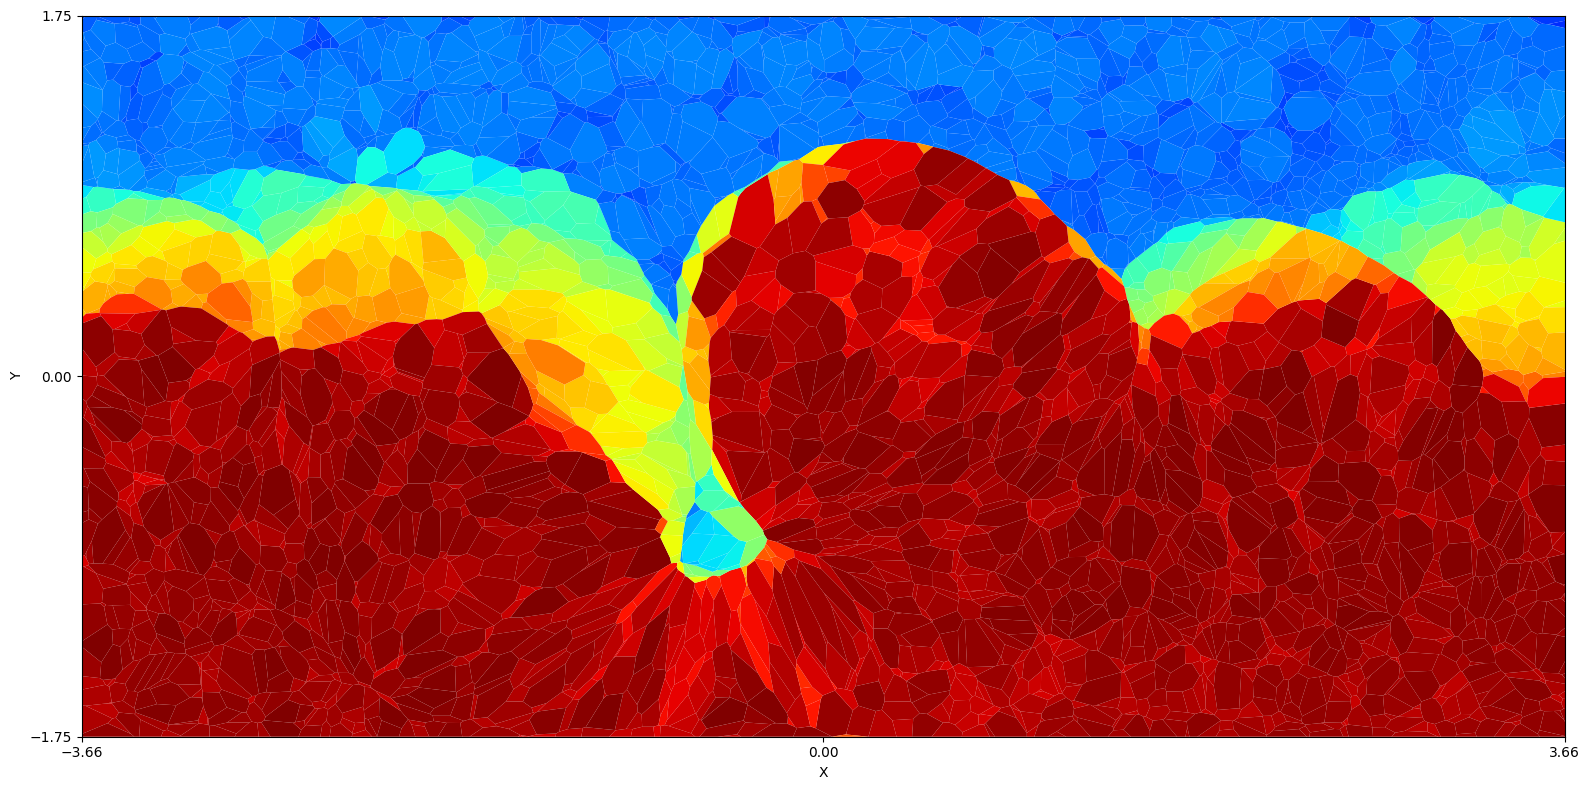

In [22]:
def find_plane_intersection(v1, v2, z_0):
    """
    Find the intersection of an edge (v1, v2) with the plane z = z_0.
    Parameters:
    - v1, v2: 3D points defining an edge of the cell.
    - z_0: The z-coordinate of the intersecting plane.
    Returns:
    - intersection: The 2D point (x, y) where the edge intersects the plane.
    - None if the edge does not intersect the plane.
    """
    z1, z2 = v1[2], v2[2]

    # Handle the case where both points are exactly on the plane
    if z1 == z_0 and z2 == z_0:
        return v1[:2], v2[:2]  # Return both points as they lie on the plane

    # If both points are on the same side of the plane, there's no intersection
    if (z1 - z_0) * (z2 - z_0) > 0:
        return None  # No intersection

    # Handle the normal case with interpolation
    t = (z_0 - z1) / (z2 - z1)
    intersection = v1 + t * (v2 - v1)
    return intersection[:2]

def slice_cell_at_plane(cell_faces, z_0):
    """
    Slice the 3D cell with the plane z = z_0 and return the 2D polygon formed by the intersection.
    Parameters:
    - cell_faces: List of faces (each face is an array of vertices) of the 3D cell.
    - z_0: The z-coordinate of the slicing plane.
    Returns:
    - 2D polygon of the intersection (list of 2D points).
    """
    intersection_points = []

    # Iterate over all faces and check each edge
    for face_verts in cell_faces:
        nv = len(face_verts)

        for i in range(nv):
            for j in range(i + 1, nv):  # Check every pair of vertices
                v1 = face_verts[i]
                v2 = face_verts[j]
                
                intersection = find_plane_intersection(v1, v2, z_0)
                if intersection is not None:
                    if isinstance(intersection, tuple):  # Handle case where both vertices are on the plane
                        intersection_points.extend(intersection)
                    else:
                        intersection_points.append(intersection)

    # Ensure unique intersection points
    intersection_points = np.array(intersection_points)
    if len(intersection_points) > 0:
        intersection_points = np.unique(intersection_points, axis=0)

    # Return the convex hull of the intersection points
    if len(intersection_points) >= 3:  # At least 3 points are needed for a convex hull
        hull = ConvexHull(intersection_points)
        return intersection_points[hull.vertices]
    else:
        return None  # Return None if not enough points to form a polygon
    

def plot_cells(x, w, ax, z_0, color_scheme, temperature_vector=None, velocity_vector=None):
    """
    Plot cells in 2D after intersecting with plane z_0, color based on temperature or velocity.
    
    Parameters:
    - x: Positions of the cells
    - w: Weights of the cells
    - ax: Matplotlib axis for plotting
    - z_0: The height of the slicing plane
    - color_scheme: 'temperature' or 'velocity'
    - temperature_vector: Vector containing temperature values for each cell
    - velocity_vector: Vector containing velocity values for each cell
    """
    D = ots.make_domain(box, True, False, False)
    pd = PowerDiagram(positions=x, weights=w, domain=D)

    tmpvtkfile = "tmp.vtk"
    pd.display_vtk(tmpvtkfile)

    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(tmpvtkfile)
    reader.Update()
    data = reader.GetOutput()

    numpy_array_of_cells = dsa.WrapDataObject(data).Cells
    numpy_array_of_points = dsa.WrapDataObject(data).Points
    numpy_array_of_nums = dsa.WrapDataObject(data).CellData['num']

    cells = vtk_to_numpy(numpy_array_of_cells)
    verts = vtk_to_numpy(numpy_array_of_points)
    nums = vtk_to_numpy(numpy_array_of_nums).astype(int)

    # Group faces by cell
    grouped_cells = group_faces_by_cell(cells, nums, verts)

    # Use colormap 'jet'
    cmap = plt.get_cmap('jet')

    # Iterate over grouped cells to slice and plot them
    for cell_index, cell_faces in grouped_cells.items():
        # Perform the slicing
        intersection_points = slice_cell_at_plane(cell_faces, z_0)

        # Skip cells with insufficient intersection points
        if intersection_points is None or len(intersection_points) < 3:
            continue

        # Compute the convex hull of the intersection points
        hull = ConvexHull(intersection_points)
        polygon_2d = intersection_points[hull.vertices]

        # Use the temperature or velocity vectors to determine the color
        if color_scheme == 'temperature' and temperature_vector is not None:
            if cell_index < len(temperature_vector):
                c = (temperature_vector[cell_index] - np.min(temperature_vector)) / (np.max(temperature_vector) - np.min(temperature_vector))
        elif color_scheme == 'velocity' and velocity_vector is not None:
            if cell_index < len(velocity_vector):
                c = (velocity_vector[cell_index] - np.min(velocity_vector)) / (np.max(velocity_vector) - np.min(velocity_vector))
        else:
            c = cell_index / (len(grouped_cells) - 1)  # Default to cell index color if no scheme provided

        # Plot the polygon using fill(), with both face and edge color
        ax.fill(polygon_2d[:, 0], polygon_2d[:, 1], facecolor=cmap(c), edgecolor='none')

def group_faces_by_cell(cells, nums, verts):
    """
    Group the faces by their corresponding cell index using the 'nums' array.
    """
    cell_to_vertices = defaultdict(list)

    idx = 0
    for k in range(len(nums)):
        nv = cells[idx]  # Number of vertices of the current face
        vidx = cells[idx + 1:idx + nv + 1]  # Indices of the vertices for this face
        face_verts = verts[vidx, :]  # Get the actual vertex coordinates
        idx += nv + 1
        
        # Group the vertices under the corresponding cell index
        cell_index = nums[k]
        cell_to_vertices[cell_index].append(face_verts)
    
    return cell_to_vertices

timestep = 400

fig, ax = plt.subplots(figsize=(16, 8), layout = 'tight')
plot_cells(Z[timestep], W[timestep], ax, 0.45, 'temperature', T[timestep], TVel[timestep])

# Set x and y limits
ax.set_xlim([-3.66, 3.66])
ax.set_ylim([-1.75, 1.75])
            
# Set specific tick marks on the x and y axes
ax.set_xticks([-3.66, 0, 3.66])
ax.set_yticks([-1.75, 0, 1.75])
            
# Set x and y labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [11]:
# Define heights and variable names for plotting
heights = [0.45 / 4, 0.45 / 2, 3 * 0.45 / 4]
variables = ['temperature', 'velocity']  # Plot both temperature and velocity
timesteps = [192, 384, 576, 768, 960, 1200]  # Define the timesteps corresponding to days

# Iterate over timesteps (corresponding to days)
for timestep in timesteps:
    
    # Calculate day number
    day_id = timestep // 48  # Assuming 48 timesteps per day
    
    # Iterate over heights
    for height in heights:
        
        # Iterate over the variables ('temperature' and 'velocity')
        for variable in variables:
            # Create the figure and axis
            fig, ax = plt.subplots(figsize=(16, 8), layout='tight')
            
            # Plot the cells
            if variable == 'temperature':
                plot_cells(Z[timestep], W[timestep], ax, height, 'temperature', T[timestep], TVel[timestep])
            else:
                plot_cells(Z[timestep], W[timestep], ax, height, 'velocity', T[timestep], TVel[timestep])
            
            # Set x and y limits
            ax.set_xlim([-3.66, 3.66])
            ax.set_ylim([-1.75, 1.75])
            
            # Set specific tick marks on the x and y axes
            ax.set_xticks([-3.66, 0, 3.66])
            ax.set_yticks([-1.75, 0, 1.75])
            
            # Set x and y labels
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            
            # Disable the color bar and the title
            ax.set_title('')  # Empty string removes the title
            
            # Construct the filename
            height_label = f'{int(height * 100)}'  # Height label for the filename
            filename = f'{variable}_day_{day_id}_height_{height_label}.png'
            
            # Save the figure
            plt.savefig(filename, dpi=300)
            plt.close()  # Close the figure to avoid memory issues with large numbers of plots


Next animate the cells

In [ ]:
import optimaltransportsolver as ots
from pysdot import PowerDiagram
import pyvista as pv
import imageio.v2 as iio

#Animate the cells

coloring = 'TVel' # Chose how to colour the cells can be temperature ('Temp'), meridional velocity ('MVel'), zonal velocity ('ZVel'), or magnitude of total velocity ('TVel')
camera = 'Spin' # Decide whether the camera is looking at the top or bottom of the domain
upper_threshold_percentage = 70 # Send to 100 to plot all 
lower_threshold_percentage = 25 # Send to 0 to plot all

# Define a dictionary to map the coloring options to cell data attribute names
coloring_to_attr_name = {
    'Temp': 'Temperature',
    'MVel': 'Meridional Velocity',
    'ZVel': 'Zonal Velocity',
    'TVel': 'Magnitude of Total Velocity'
}

# Construct the domain
D = ots.make_domain(box, False, False, False)

# Set up the animation parameters
n_frames = len(W)  # Number of frames
angle_increment = 360 / n_frames

# Create an empty list to store frames
frames = []

# Store the colouring intervals
if coloring == 'MVel':
    MVel = [mv[~np.isnan(mv)] for mv in MVel]
    minval = np.min(MVel.flatten())
    maxval = np.max(MVel.flatten())
elif coloring == 'ZVel':
    ZVel = [zv[~np.isnan(zv)] for zv in ZVel]
    minval = np.min(ZVel.flatten())
    maxval = np.max(ZVel.flatten())
elif coloring == 'TVel':
    TVel = [tv[~np.isnan(tv)] for tv in TVel]
    minval = np.min(TVel)
    maxval = np.max(TVel)
elif coloring == 'Temp':
    T = [t[~np.isnan(t)] for t in T]
    minval = np.min(T)
    maxval = np.max(T)
else:
    raise ValueError('Please specify how you want to colour the cells')

# Set the colouring threshold
upper_threshold_value = maxval * (upper_threshold_percentage / 100.0)
lower_threshold_value = maxval * (lower_threshold_percentage / 100.0)

# Generate frames for the animation
for i in range(n_frames):

    # Remove NaN entries from positions and corresponding weights
    valid_mask = ~np.isnan(Z[i]).any(axis=1)
    Zmod = Z[i][valid_mask]
    Wmod = W[i][valid_mask]

    #Draw the tessellation
    pd = PowerDiagram(positions = Zmod , weights = Wmod , domain = D)

    # Save the results in a .vtk file
    filename = "./data/cells.vtk"
    pd.display_vtk(filename)

    # Store the volumes in an array
    if coloring == 'MVel':
        colours = np.array(MVel[i])
    elif coloring == 'ZVel':
        colours = np.array(ZVel[i])
    elif coloring == 'TVel':
        colours = np.array(TVel[i])
    elif coloring == 'Temp':
        colours = np.array(T[i]) 
    else:
        raise ValueError('Please specify how you want to colour the cells')

    # Read the data
    grid=pv.read(filename)

    # Create cell data that gives the cell volumes, this allows us to colour the cells
    opacities = np.where((colours >= lower_threshold_value) & (colours <= upper_threshold_value), 1, 0)  # Fully opaque in the interval, transparent outside it 
    cell_opacities = opacities[grid.cell_data['num'].astype(int)]
    cell_colours = colours[grid.cell_data['num'].astype(int)]
    grid.cell_data[coloring_to_attr_name[coloring]] = cell_colours
    grid.cell_data['opacity'] = cell_opacities

    # plot the data with an automatically created plotter, for a static picture use backend='static'
    plotter = pv.Plotter(window_size=[800,800], notebook = False, off_screen=True)
    plotter.add_mesh(grid, clim = [minval, maxval], cmap = 'jet', opacity = 'opacity')

    # Set the camera for a 2D view at either the bottom or the top
    if camera == 'Angled':
        pass
    elif camera == 'Top':
        plotter.camera_position = 'xy'
    elif camera == 'Bottom':
        plotter.camera_position = 'xy'
        plotter.camera.elevation = 180
        plotter.camera.roll += 360
    elif camera == 'Spin':
        angle = i * angle_increment
        x = 11 * np.sin(np.radians(angle))  # Radius and sine for x-coordinate
        y = 11 * np.cos(np.radians(angle))  # Radius and cosine for y-coordinate
        plotter.camera_position = [(x, y, 11), (0, 0, 0), (0, 0, 1)]
    else:
        raise ValueError('Please specify how you want the camera oriented')

    # Render the frame
    plotter.show()

    # Get the frame as an image array
    frame = plotter.screenshot(transparent_background=True)

    # Add the frame to the list of frames
    frames.append(frame)

# Save the frames as an animation file
output_file = './animations/SG_Cells.gif'
iio.mimwrite(output_file, frames, format = 'gif', fps = 30)

# Combine and syncronize the animations

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

# Function to read GIF frames
def read_gif(gif_path):
    img = Image.open(gif_path)
    frames = []
    try:
        while True:
            frames.append(img.copy())
            img.seek(len(frames))
    except EOFError:
        pass
    return frames

# Paths to your GIFs
gif1_path = './animations/SG_Cells_A=-0.5.gif'
gif2_path = './animations/SG_Seeds_2D_A=-0.5.gif'
#gif3_path = './animations/SG_Centroids_2D.gif'

# Read GIF frames
frames1 = read_gif(gif1_path)
frames2 = read_gif(gif2_path)
#frames3 = read_gif(gif3_path)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax in axes:
    ax.axis('off') # Turn off the axis

fig.subplots_adjust(wspace=0.1)  # Adjust the width space

# Display each GIF on a separate subplot
ims = []

for ax, frames in zip(axes, [frames1, frames2]): #, frames3]):
    im = ax.imshow(frames[0], animated=True)
    ims.append([im])

# Update function for the animation
def update(frame):
    for im, frames in zip(ims, [frames1, frames2]): #, frames3]):
        im[0].set_array(frames[frame])

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(frames1), repeat=False, blit=False)

# Save the animation (uncomment the line below to save)
ani.save('./animations/Combined_Animation_A=-0.5.gif', writer='pillow', fps=30, dpi=170)